In [20]:
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize
from skimage import data
from scipy.misc import imresize
import tensorflow as tf

%matplotlib inline
plt.style.use('seaborn-ticks')
sys.path.append("/home/vishal/Workspace/nn-ocr")

In [11]:
# From pkmital/pycadl.
import cadl
# From this repository.
import chars_vaegan
# From indraastra/nn-ocr.
from dataset import dataset, en
import fonts as font_utils

In [77]:
SIZE = 100

In [72]:
LABELS = en.get_labels()
FONTS = [font_utils.load_font(f) for f in en.get_fonts()]

def render_char(char, font, size=SIZE):
    np_img = np.asarray(font_utils.char_to_glyph(char, font, size), np.uint8)
    return np.tile(np.expand_dims(np_img, -1), 
                   (1, 1, 3))

def render_chars(chars, fonts, size=SIZE):
    return np.array([[render_char(char, font, size) for char in chars]
                     for font in fonts])

def show_images(imgs):
    plt.imshow(np.hstack(np.hstack(imgs)), cmap='gray')

In [147]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = chars_vaegan.load_vaegan("vaegan_model", sess)

def preprocess(img):
    img = imresize(img, (SIZE, SIZE))
    return img / 255.

def postprocess(recon):
    return (np.clip(recon / recon.max(), 0, 1) * 255).astype(np.uint8)

print(model.keys())

INFO:tensorflow:Restoring parameters from vaegan_model/vaegan-700
VAE model restored.
dict_keys(['loss_fake', 'z_samp', 'x_tilde_samp', 'loss_dis', 'loss_D_llike', 'x_tilde', 'loss_GAN', 'gamma', 'loss_enc', 'x', 'loss_gen', 'z', 'loss_real', 'loss_samp'])


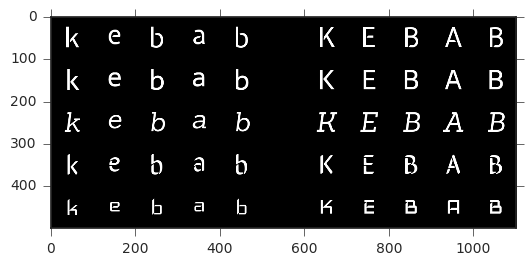

In [115]:
# Generate renderings of this text for 5 different fonts.
imgs = render_chars('kebab KEBAB', random.sample(FONTS, 5))
show_images(imgs)

In [151]:
# Generate reconstructions of the above images.
imgs_xs = np.array([preprocess(img) for img in imgs.reshape((-1, SIZE, SIZE, 3))])
recon, zs = sess.run([model['x_tilde'], model['z']], 
                     feed_dict={model['x']: imgs_xs})
imgs_recon = np.array([postprocess(img) for img in recon]).reshape(imgs.shape)
imgs_zs = zs.reshape((imgs.shape[0], imgs.shape[1], -1))

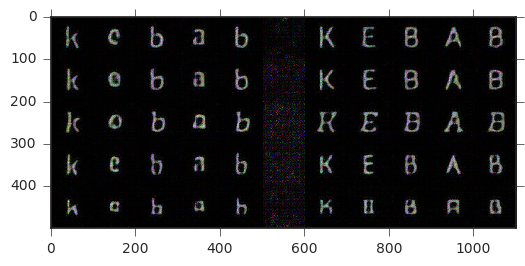

In [152]:
# Display reconstructions of the original text.
show_images(imgs_recon)

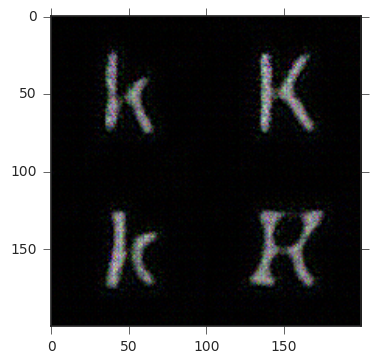

In [155]:
show_images([[imgs_recon[0, 0], imgs_recon[0, 6]],
             [imgs_recon[2, 0], imgs_recon[2, 6]]])

In [186]:
# Let's try and reconstruct the capital letters by playing with the latent space.
# We do this by subtracting encodings for the lowercase letters from corresponding
# encodings of the uppercase letters, then averaging the result by letter. We add
# the averages back to the lowercase encodings and see what the result is after
# reconstruction below.
new_zs = (imgs_zs[0:, 6:] - imgs_zs[0:, 0:5]).mean(axis=0) + imgs_zs[0:, 0:5]

In [187]:
recon = sess.run(model['x_tilde'], 
                 feed_dict={model['z']: new_zs.reshape(-1, 64)})
new_recon = np.array([postprocess(img) for img in recon]).reshape((5, 5, SIZE, SIZE, 3))

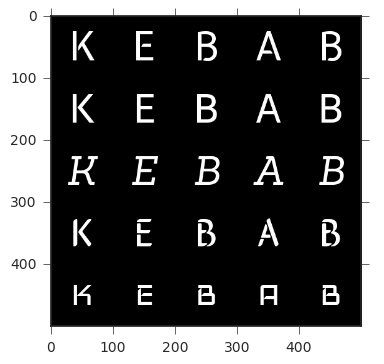

In [188]:
# ORIGINAL.
show_images(imgs[:, 6:])

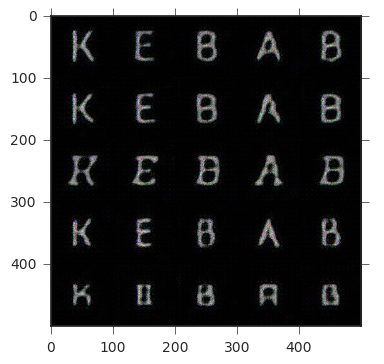

In [189]:
# RECONSTRUCTED FROM ENCODING.
show_images(imgs_recon[:, 6:])

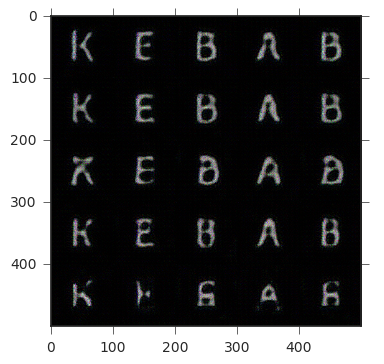

In [190]:
# RECONSTRUCTED FROM ENCODING MATH.
show_images(new_recon)